In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
except Exception:
    pass

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2

# Coverage
from dataeval.metrics.bias import coverage

# Clustering
from dataeval.metrics.estimators import clusterer
from dataeval.utils.data import batch_voc

# Dataset and model
from dataeval.utils.data.datasets import VOCDetection
from dataeval.utils.torch.models import ResNet18

# Set default torch device for notebook
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
resnet = ResNet18()

# Uncomment the line below to see the model architecture in detail
# print(resnet)

In [4]:
# Load the training dataset using model specific transforms
transforms = v2.Compose([v2.ToImage(), v2.Resize((256, 256)), v2.ToDtype(torch.float32, scale=True)])

dataset = VOCDetection(root="./data", year="2011", image_set="train", download=True, transform=transforms)

print(dataset.info())

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


Train
-----
Dataset VOCDetection
    Number of datapoints: 5717
    Root location: ./data
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
           )



In [5]:
embeddings, _ = batch_voc(dataset=dataset, model=resnet)

embeddings.shape

torch.Size([5717, 128])

In [6]:
print(f"Max value: {embeddings.max()}")
print(f"Min value: {embeddings.min()}")

Max value: 2.7331137657165527
Min value: -3.2014143466949463


In [7]:
# Puts the embeddings onto the unit interval [0-1]
normalized_embs = (embeddings - embeddings.min()) / (embeddings.max() - embeddings.min())

print(f"Max value: {normalized_embs.max()}")
print(f"Min value: {normalized_embs.min()}")

Max value: 1.0
Min value: 0.0


In [8]:
output = clusterer(normalized_embs)

In [9]:
outliers = output.find_outliers()

print(f"Number of outliers: {len(outliers)}")

Number of outliers: 3616


In [10]:
print(f"Percent of outliers: {(100 * len(outliers) / len(dataset)):.2f}%")

Percent of outliers: 63.25%


In [11]:
def plot_two_rows(indices: list[int], count=3):
    _, axs = plt.subplots(2, count, figsize=(8, 8))

    for i, ax in enumerate(axs.flat):
        curr_image = dataset[indices[i]][0]

        # Permutes image from torch shape CHW to matplotlib shape HWC
        ax.imshow(torch.permute(curr_image, (1, 2, 0)).cpu().numpy())
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
# To use the flagged outliers, uncomment the line below
indices = outliers

# To use unflagged images, uncomment the line below
# indices = list(set(range(len(dataset))) - set(outliers)

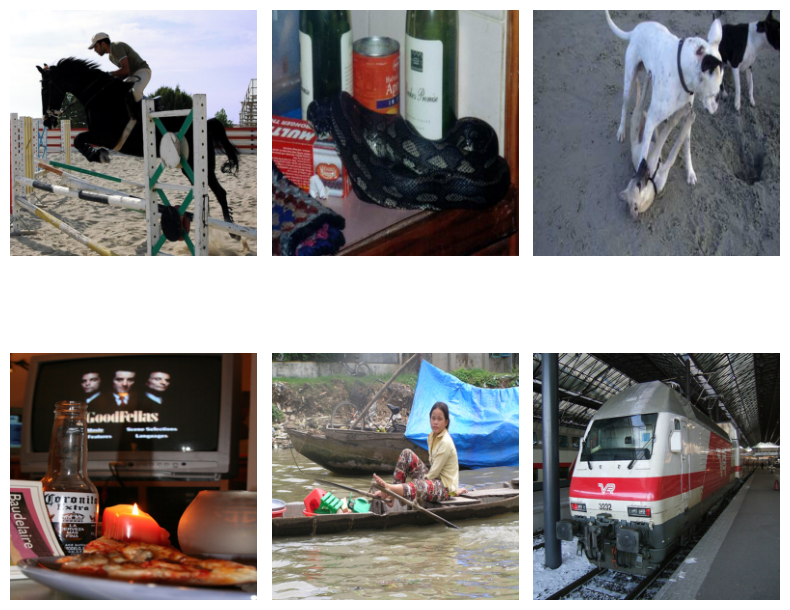

In [13]:
plot_two_rows(indices.tolist(), count=3)

In [14]:
cov = coverage(embeddings=normalized_embs)

print(f"Number of uncovered images: {len(cov.uncovered_indices)}")

Number of uncovered images: 57


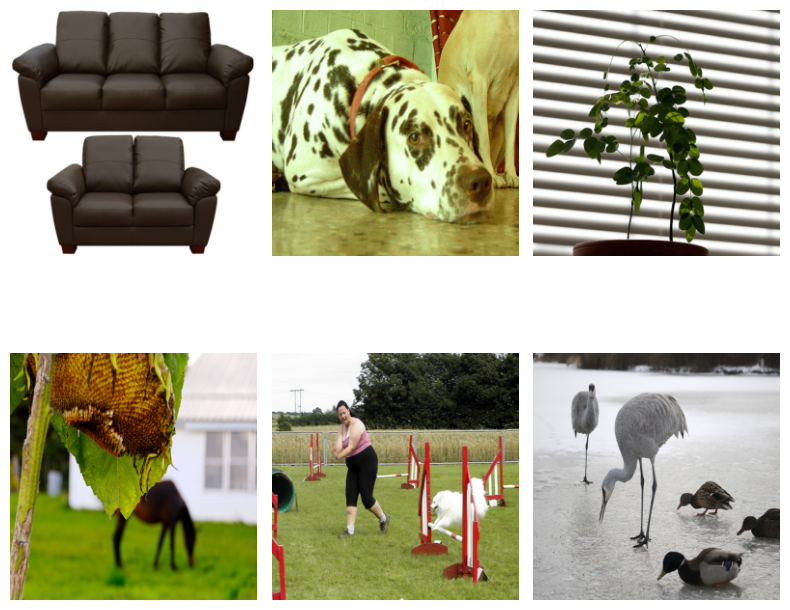

In [15]:
plot_two_rows(indices=cov.uncovered_indices.tolist(), count=3)

In [16]:
uncovered_outliers = set(cov.uncovered_indices.tolist()).intersection(set(outliers))

print(f"Number of outliers found as uncovered images: {len(uncovered_outliers)}")

Number of outliers found as uncovered images: 57
